### Classifying code snippets based on Levenshtein distance for Curriculum Learning. 🪣

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import FloatProgress
from IPython.display import display, HTML
from os import listdir, makedirs
from os.path import isfile, join
from time import sleep

Global variables

In [29]:
DATA_FOLDER = "data"
DATA_SIZE = "medium"
DATA_PATH = f"./{DATA_FOLDER}/{DATA_SIZE}/"
FILE_TYPE_TO_MODIFY = "train"
OUTPUT_FOLDER = "dataCL_v2"
OUTPUT_PATH = f"./{OUTPUT_FOLDER}/{DATA_SIZE}/"

Levenshtein distance for code snippets: Number of token flips needed to convert buggy code to fixed.
https://en.wikipedia.org/wiki/Levenshtein_distance

In [30]:
def levenshtein(buggy_instance, fixed_instance):
    b = buggy_instance.split(" ")
    f = fixed_instance.split(" ")
    
    n_cols = len(b) + 1
    n_rows = len(f) + 1

    D = np.array(
        [ [0 for i in range(n_cols)] for j in range (n_rows) ]
    )

    for i in range(n_cols):
        D[0][i] = i

    for i in range(n_rows):
        D[i][0] = i

    for i in range(1, n_rows):
        for j in range(1, n_cols):
            if f[i-1] == b[j-1]:
                D[i][j] = D[i-1][j-1]
            else:
                insertion = D[i][j - 1]
                deletion = D[i - 1][j]
                replacement = D[i - 1][j - 1]
                D[i][j] = 1 + min(insertion, deletion, replacement)


    return D[len(f)][len(b)]

Opening the files and exctracting the data to be classified

In [31]:
input_files = [f for f in listdir(DATA_PATH) if (isfile(join(DATA_PATH, f)) and FILE_TYPE_TO_MODIFY in f)]
input_buggy = [f for f in input_files if f.endswith(".buggy")][0]
input_fixed = [f for f in input_files if f.endswith(".fixed")][0]

# Open files 
buggy = open(DATA_PATH+input_buggy)
fixed = open(DATA_PATH+input_fixed)

instances_buggy = np.array(buggy.read().splitlines())
instances_fixed = np.array(fixed.read().splitlines())

assert len(instances_buggy) == len(instances_fixed)

distances = np.array([])

for code_buggy, code_fixed in tqdm(zip(instances_buggy, instances_fixed), total=len(instances_buggy)):
    distances = np.append(distances,(levenshtein(code_buggy, code_fixed)))

# Close files
buggy.close()
fixed.close()

print(f"Calculated LD of {len(distances)} code snippets")


  0%|          | 0/52364 [00:00<?, ?it/s]

Calculated LD of 52364 code snippets


Statistical analysis
- <1st quartile (Low complexity code)
- 1st to Median (Low-Medium complexity code)
- Median to 3rd quartile (Medium-high complexity code)
- \>3rd quartile (High complexity code)

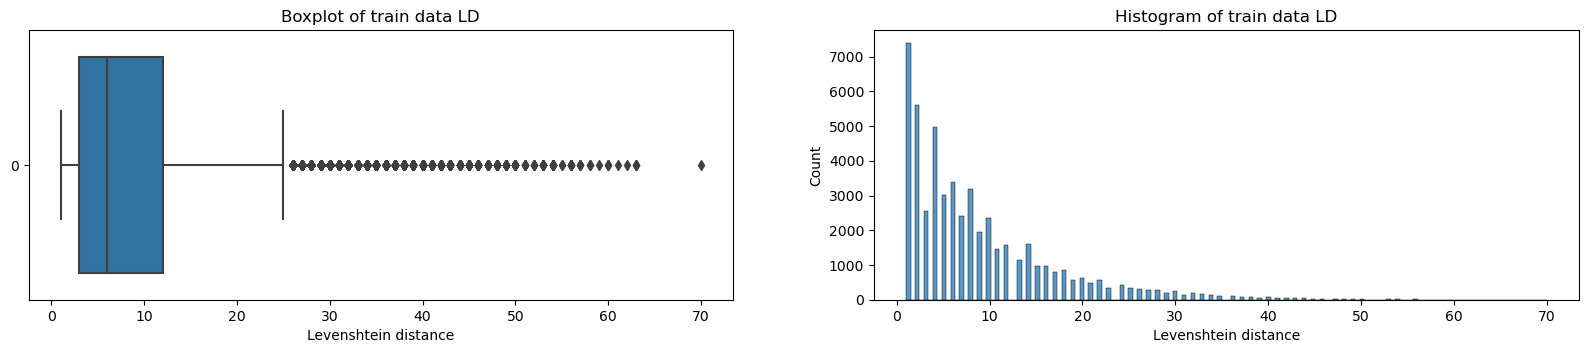

1st quartile 3.0
Median 6.0
3rd quartile 12.0


,Class,Size of the class (instances),Size of the class (percentage)
0,low,15559,29.71
1,low_medium,11386,21.74
2,medium_high,12949,24.73
3,high,12470,23.81


Changing the strategy to version 2 where a class holds instances of the previous class and the current class


,Class,Size of the class (instances),Size of the class (percentage)
0,low,15559,29.71
1,low_medium,26945,51.46
2,medium_high,39894,76.19
3,high,52364,100.00


In [32]:
# Plot data
plt.rcParams["figure.figsize"] = [20.00, 3.50]
f, axes = plt.subplots(1, 2)
sns.boxplot(data=distances, orient="h", ax=axes[0]).set(xlabel="Levenshtein distance", title=f"Boxplot of {FILE_TYPE_TO_MODIFY} data LD")
sns.histplot(data=distances, ax=axes[1]).set(xlabel="Levenshtein distance", title=f"Histogram of {FILE_TYPE_TO_MODIFY} data LD")
plt.show()

Q1 = np.percentile(distances, 25)
med = np.median(distances)
Q3 = np.percentile(distances, 75)
print(f"1st quartile {Q1}")
print(f"Median {med}")
print(f"3rd quartile {Q3}")

low = np.where(distances <= Q1)
low_medium = np.where((Q1 < distances) & (distances <= med))
medium_high = np.where((med < distances) & (distances <= Q3))
high = np.where(Q3 < distances)

low_array = distances[low]
low_medium_array = distances[low_medium]
medium_high_array = distances[medium_high]
high_array = distances[high]

classes = {
    "Class" : ["low", "low_medium", "medium_high", "high"],
    "Size of the class (instances)" : [len(distances[low]), len(distances[low_medium]), len(distances[medium_high]), len(distances[high])],
    "Size of the class (percentage)" : [round(len(distances[low])/len(distances)*100,2), round(len(distances[low_medium])/len(distances)*100,2), round(len(distances[medium_high])/len(distances)*100,2), round(len(distances[high])/len(distances)*100,2)]

}

classes = pd.DataFrame(classes).reset_index(drop=True)
display(HTML(classes.to_html()))

print("Changing the strategy to version 2 where a class holds instances of the previous class and the current class")

low_array = low_array
low_medium_array = np.append(low_array, low_medium_array)
medium_high_array = np.append(low_medium_array, medium_high_array)
high_array = np.append(medium_high_array, high_array)

classes = {
    "Class" : ["low", "low_medium", "medium_high", "high"],
    "Size of the class (instances)" : [low_array.size, low_medium_array.size, medium_high_array.size, high_array.size],
    "Size of the class (percentage)" : [round(low_array.size/len(distances)*100,2), round(low_medium_array.size/len(distances)*100,2), round(medium_high_array.size/len(distances)*100,2), round(high_array.size/len(distances)*100,2)]
}
classes = pd.DataFrame(classes).reset_index(drop=True)
display(HTML(classes.to_html()))

Splitting the data into 4 different sets

In [33]:
# Make output dir
makedirs(OUTPUT_PATH)

input_files = [f for f in listdir(DATA_PATH) if (isfile(join(DATA_PATH, f)) and FILE_TYPE_TO_MODIFY in f)]
input_buggy = [f for f in input_files if f.endswith(".buggy")][0]
input_fixed = [f for f in input_files if f.endswith(".fixed")][0]

# Open files 
buggy = open(DATA_PATH+input_buggy)
fixed = open(DATA_PATH+input_fixed)

instances_buggy = np.array(buggy.readlines())
instances_fixed = np.array(fixed.readlines())


assert len(instances_buggy) == len(instances_fixed) == len(distances)

for buggy_line, fixed_line, dist in zip(instances_buggy, instances_fixed, distances):

    if dist <= Q1:
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.1.buggy", "a") as f:
            f.write(buggy_line)
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.1.fixed", "a") as f:
            f.write(fixed_line)

    if dist <= med:
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.2.buggy", "a") as f:
            f.write(buggy_line)
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.2.fixed", "a") as f:
            f.write(fixed_line)

    if dist <= Q3:
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.3.buggy", "a") as f:
            f.write(buggy_line)
        with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.3.fixed", "a") as f:
            f.write(fixed_line)
    
    with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.4.buggy", "a") as f:
        f.write(buggy_line)
    with open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.4.fixed", "a") as f:
        f.write(fixed_line)

buggy_1 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.1.buggy"))
fixed_1 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.1.fixed"))
buggy_2 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.2.buggy"))
fixed_2 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.2.fixed"))
buggy_3 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.3.buggy"))
fixed_3 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.3.fixed"))
buggy_4 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.4.buggy"))
fixed_4 = sum(1 for line in open(f"{OUTPUT_PATH}/{FILE_TYPE_TO_MODIFY}.buggy-fixed.4.fixed"))

assert buggy_1 == fixed_1
assert buggy_2 == fixed_2
assert buggy_3 == fixed_3
assert buggy_4 == fixed_4

print(f"Sucesfully wrote the data in curriculum form in {OUTPUT_FOLDER}")
print(f"Number of instances in class 1: {buggy_1}")
print(f"Number of instances in class 2: {buggy_2}")
print(f"Number of instances in class 3: {buggy_3}")
print(f"Number of instances in class 4: {buggy_4}")



Sucesfully wrote the data in curriculum form in dataCL_v2
Number of instances in class 1: 15559
Number of instances in class 2: 26945
Number of instances in class 3: 39894
Number of instances in class 4: 52364
